This notebook is a standalone script that plots sample BISC recordings in NWB format <br><br>
The provided NWB data is from a porcine SSEP study. In this study,
- Medial region of the subject's snout was electrically stimulated using clinical EEG
- BISC implant recorded from the subdural space, over the sensorimotor cortex of the subject

The nwb files we provide contain the following: <br>
- Metadata of the experiment
- Raw BISC recording (`ElectricalSeries`) from 16x16 channels at 33.9kS/s per channel
- Three EEG pulse train (`EEG output pulses`):
    - One pulse to stimulate the porcine subject
    - Two pulses to provide synchronization between EEG machine and BISC system

Please refer to Part 2 of this script for more information about `ElectricalSeries` and `EEG output pulses`

This script requires `pynwb` package which can be installed by invoking: `$ pip install -U pynwb` <br>
This script was created based on based on PyNBW tutorial in this [Link](https://nwb-overview.readthedocs.io/en/latest/conversion_tutorial/03_nwb_apis.html) <br>

Please define the file path in `nwb_file_defs.py` prior to running the notebook

In [16]:
import os
import numpy as np
from matplotlib import pyplot as plt

from pynwb import NWBHDF5IO

In [17]:
""" Load NWB """
# Change the string below to the path of the file on your computer

from nwb_file_defs import load_dir, filename

filepath = os.path.join(load_dir, filename)
io = NWBHDF5IO(filepath, 'r')  # open the file in read mode 'r'
nwb = io.read()

##### Part 1. Print Metadata

In [18]:
""" print NWB """
nwb

Data type,float64
Shape,"(3, 123361)"
Array size,2.82 MiB
Chunk shape,None
Compression,None
Compression opts,None
Compression ratio,1.0
Data type,object
Shape,"(3,)"
Array size,24.00 bytes
Chunk shape,None


##### Part2: Plot Time Series Data

The provided files have two types of series data: `ElectricalSeries` and `EEG output pulses`

- `ElectricalSeries` is an array of [`time series` x `channels`] that represent the raw voltage recordings from each BISC channel

    - `time series` represents the raw *input-referred voltage* of each channel recording at 33.9 kS/s without applying any filtering. Raw input-referred voltages were computed by converting the 10'b digitized output to voltage and dividing by the system gain. Note that saturated samples (values too close to Ground or VDD) have been converted to np.NaN. *Saturation* occurs when the recorded signal amplitude exceeds the dynamic range of our device

    - `channels = 256`; the BISC implant was configured to record from 16x16 channels. See NWB nwb.electrodes for more details about the channel locations.

- `EEG output pulses` has three lists that represent the time series of signals produced by the EEG machine

    - The first list is the electrical stimulation current (mA) that is delivered to the subject's snout
    - The second and third lists represent the synchronization pulse train delivered to the BISC relay station. The EEG machine was configured to deliver sync pulses ~50 ms after the electrical stimulation. Note that the sync pulses are captured by the BISC relay station only when the implant is recording, at the same sampling rate of 33.9 kS/s
    - Synchronization pulses traveled through physically long wires which created artifacts that are present in BISC implant's neural recordings. To avoid these artifacts from affecting the analysis, segments in [-50, +50) msec w.r.t. the stimulation was used for our paper's analysis

In [19]:
# NOTE about nwb.electrodes
# Per NWB documentation, x/y/z directions are defined as follows:
# x-axis is anterior-posterior (+x is posterior)
# y-axis is superior-inferior (+y is inferior), irrelevant to BISC
# z-axis is left-right (+z is right)
# x-axis aligns with BISC row index (higher row is posterior i.e. caudal)
# y-axis is irrelevant to BISC orientation
# z-axis aligns with BISC column index (higher column is right i.e. medial)

In [20]:
rec_data = nwb.acquisition['ElectricalSeries']
eeg_data = nwb.acquisition['EEG output pulses']

In [21]:
""" check that BISC recordings and EEG have same time series properties """
assert rec_data.data.shape[0] == eeg_data.data.shape[1]
assert rec_data.rate == eeg_data.rate
assert rec_data.starting_time == eeg_data.starting_time == 0

In [22]:
""" fetch the data arrays """
voltage_data = np.array(rec_data.data).T

stim_pulses = eeg_data.data[0]
artifact_pulses = eeg_data.data[1]
sync_pulses = eeg_data.data[2]

t = np.arange(0, voltage_data.shape[1])*(1/rec_data.rate)

Please modify the following variables as needed: <br>
- `(r, c)`: Row and column that defines which BISC channel to plot (`r` and `c` are integers from 0 to 15)
- `(t0, t1)`: Time segment to plot (unit in seconds)

In [23]:
""" pick what to plot """ 
# pick which channel to plot
r, c = 3, 5 # pick both from (0, 1, 2, ..., 15)

# pick which time segment to plot
t0, t1 = 1, 2 # (s)

Text(0.5, 1.0, 'Single Channel (Address: row 3, col 5), Raw Data Example')

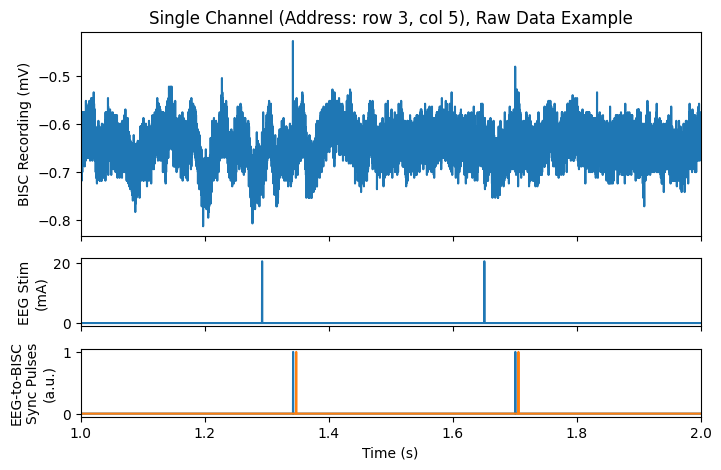

In [24]:
""" plot a sample channel """
fig, ax = plt.subplots(3, 1, figsize=(8, 5), sharex=True,
                       gridspec_kw={'height_ratios': [3, 1, 1]})

ch = 16*r + c
ch_data = voltage_data[ch,:]

i0 = np.where(t > t0)[0][0]
i1 = np.where(t > t1)[0][0]

ax[0].set_xlim(t0, t1)

ch = 16*10 + 10
ax[0].plot(t[i0:i1], ch_data[i0:i1]/1e-3)
ax[1].plot(t[i0:i1], stim_pulses [i0:i1])
ax[2].plot(t[i0:i1], artifact_pulses [i0:i1])
ax[2].plot(t[i0:i1], sync_pulses [i0:i1])

ax[0].set_ylabel('BISC Recording (mV)')
ax[1].set_ylabel('EEG Stim\n(mA)')
ax[2].set_ylabel('EEG-to-BISC\nSync Pulses\n(a.u.)')
ax[2].set_xlabel('Time (s)')

ax[0].set_title(f'Single Channel (Address: row {r}, col {c}), Raw Data Example')